# Unsupervised image denoising

## Import libraries

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, Lambda, Normalize, Grayscale
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm.notebook import tqdm
import torch.nn.functional as F
import os

## Load data

In [2]:
directory_data  = './'
filename_data   = 'assignment_08_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))


original_train = data['original_train'] 
noise_train    = data['noise_train']

original_test = data['original_test'] 
noise_test    = data['noise_test']

print('*************************************************')
print('size of noise_train    : ', noise_train.shape)
print('*************************************************')
print('size of noise_test    : ', noise_test.shape)
print('*************************************************')
print('number of training image :', noise_train.shape[0])
print('height of training image :', noise_train.shape[1])
print('width of training image  :', noise_train.shape[2])
print('*************************************************')
print('number of testing image :', noise_test.shape[0])
print('height of testing image :', noise_test.shape[1])
print('width of testing image  :', noise_test.shape[2])
print('*************************************************')


*************************************************
size of noise_train    :  (2000, 64, 64)
*************************************************
size of noise_test    :  (900, 64, 64)
*************************************************
number of training image : 2000
height of training image : 64
width of training image  : 64
*************************************************
number of testing image : 900
height of testing image : 64
width of testing image  : 64
*************************************************


## Hyper parameters

In [3]:
device        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==================================================
# determine optimal hyper-parameters to obtain best testing performance
number_epoch    = 100
size_minibatch  = 16
learning_rate   = 0.01
momentum        = 0.9
weight_decay    = 0.0001
weight_total_variation = 0.01
# ==================================================

## Costumize dataloader for pytorch

In [4]:
class dataset (Dataset):
  def  __init__(self, original,noise):

    self.original = original
    self.noise    = noise
        
  def __getitem__(self, index):

    original    = self.original[index]
    noise       = self.noise[index]
    
    original   = torch.FloatTensor(original).unsqueeze(dim=0)
    noise      = torch.FloatTensor(noise).unsqueeze(dim=0)


    return (original , noise)
  
  def __len__(self):

     return self.original.shape[0]

## Construct datasets and dataloaders for training and testing

In [5]:
dataset_train = dataset(original_train, noise_train) 
dataset_test  = dataset(original_test, noise_test) 

dataloader_train = DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_test  = DataLoader(dataset_test,  batch_size=size_minibatch, shuffle=False, drop_last=True) 

## Shape of the data with data loader

In [6]:
(original_train, noise_train)   = dataset_train[0]
(original_test, noise_test)     = dataset_test[0]

print('************************************************************')
print('shape of the original image in the training dataset:', original_train.shape)
print('shape of the noisy image in the training dataset:', noise_train.shape)
print('************************************************************')
print('shape of the original image in the testing dataset:', original_test.shape)
print('shape of the noisy image in the testing dataset:', noise_test.shape)
print('************************************************************')

************************************************************
shape of the original image in the training dataset: torch.Size([1, 64, 64])
shape of the noisy image in the training dataset: torch.Size([1, 64, 64])
************************************************************
shape of the original image in the testing dataset: torch.Size([1, 64, 64])
shape of the noisy image in the testing dataset: torch.Size([1, 64, 64])
************************************************************


## Class for the neural network

In [7]:
class UnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetBlock, self).__init__()
        self.ublock = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(),
        )

    def forward(self, x):
        out = self.ublock(x)
        
        return out

class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # -------------------------------------------------
        # Encoder
        # -------------------------------------------------
        self.e_layer1_1 = UnetBlock(1, 64)
        self.e_layer1_2 = UnetBlock(64, 64)
        self.down1 = nn.MaxPool2d(kernel_size=2)

        self.e_layer2_1 = UnetBlock(64, 128)
        self.e_layer2_2 = UnetBlock(128, 128)
        self.down2 = nn.MaxPool2d(kernel_size=2)

        self.e_layer3_1 = UnetBlock(128, 256)
        self.e_layer3_2 = UnetBlock(256, 256)
        self.down3 = nn.MaxPool2d(kernel_size=2)

        self.e_layer4_1 = UnetBlock(256, 512)
        self.e_layer4_2 = UnetBlock(512, 512)
        self.down4 = nn.MaxPool2d(kernel_size=2)

        self.e_layer5_1 = UnetBlock(512, 1024)
        
        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------
        self.d_layer5_1 = UnetBlock(1024, 512)

        self.up4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)
        self.d_layer4_1 = UnetBlock(1024, 512)
        self.d_layer4_2 = UnetBlock(512, 256)

        self.up3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)
        self.d_layer3_1 = UnetBlock(512, 256)
        self.d_layer3_2 = UnetBlock(256, 128)

        self.up2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)
        self.d_layer2_1 = UnetBlock(256, 128)
        self.d_layer2_2 = UnetBlock(128, 64)

        self.up1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)
        self.d_layer1_1 = UnetBlock(128, 64)
        self.d_layer1_2 = UnetBlock(64, 32)
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.Sigmoid(),
        )
        
        # -------------------------------------------------
        # Network
        # -------------------------------------------------
        self.network = nn.Sequential(
                        self.e_layer1_1,
                        self.e_layer1_2,
                        self.down1,
                        self.e_layer2_1,
                        self.e_layer2_2,
                        self.down2,
                        self.e_layer3_1,
                        self.e_layer3_2,
                        self.down3,
                        self.e_layer4_1,
                        self.e_layer4_2,
                        self.down4,
                        self.e_layer5_1,

                        self.d_layer5_1,
                        self.up4,
                        self.d_layer4_1,
                        self.d_layer4_2,
                        self.up3,
                        self.d_layer3_1,
                        self.d_layer3_2,
                        self.up2,
                        self.d_layer2_1,
                        self.d_layer2_2,
                        self.up1,
                        self.d_layer1_1,
                        self.d_layer1_2,

                        self.conv1,
        )
        self.initialize_weight()

    def forward(self,x):
        e_out1_1 = self.e_layer1_1(x)
        e_out1_2 = self.e_layer1_2(e_out1_1)
        e_down1 = self.down1(e_out1_2)

        e_out2_1 = self.e_layer2_1(e_down1)
        e_out2_2 = self.e_layer2_2(e_out2_1)
        e_down2 = self.down2(e_out2_2)

        e_out3_1 = self.e_layer3_1(e_down2)
        e_out3_2 = self.e_layer3_2(e_out3_1)
        e_down3 = self.down3(e_out3_2)

        e_out4_1 = self.e_layer4_1(e_down3)
        e_out4_2 = self.e_layer4_2(e_out4_1)
        e_down4 = self.down4(e_out4_2)

        e_out5_1 = self.e_layer5_1(e_down4)

        d_out5_1 = self.d_layer5_1(e_out5_1)

        d_up4 = self.up4(d_out5_1)
        d_out4_0 = torch.cat([d_up4, e_out4_2], 1)
        d_out4_1 = self.d_layer4_1(d_out4_0)
        d_out4_2 = self.d_layer4_2(d_out4_1)

        d_up3 = self.up3(d_out4_2)
        d_out3_0 = torch.cat([d_up3, e_out3_2], 1)
        d_out3_1 = self.d_layer3_1(d_out3_0)
        d_out3_2 = self.d_layer3_2(d_out3_1)

        d_up2 = self.up2(d_out3_2)
        d_out2_0 = torch.cat([d_up2, e_out2_2], 1)
        d_out2_1 = self.d_layer2_1(d_out2_0)
        d_out2_2 = self.d_layer2_2(d_out2_1)

        d_up1 = self.up1(d_out2_2)
        d_out1_0 = torch.cat([d_up1, e_out1_2], 1)
        d_out1_1 = self.d_layer1_1(d_out1_0)
        d_out1_2 = self.d_layer1_2(d_out1_1)

        out = self.conv1(d_out1_2)

        return out

    # ======================================================================
    # initialize weights
    # ======================================================================
    def initialize_weight(self):
            
        for m in self.network.modules():
            
            if isinstance(m, nn.Conv2d):

                nn.init.kaiming_normal_(m.weight) 
                
                if m.bias is not None:

                    nn.init.constant_(m.bias, 1)
                    pass
                    
            elif isinstance(m, nn.BatchNorm2d):
                
                nn.init.normal_(m.weight, 1, 0.01)
                nn.init.constant_(m.bias, 1)
                
            elif isinstance(m, nn.Linear):
                
                nn.init.kaiming_normal_(m.weight) 

                if m.bias is not None:
                    
                    nn.init.constant_(m.bias, 1)
                    pass

## Build the network

In [8]:
model = Network().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum , weight_decay=weight_decay)

## Compute prediction (denoised image)

In [9]:
def compute_prediction(model, input):
    
    # ==================================================
    # fill up the blank
    prediction = model(input)
    # ==================================================
    
    return prediction

## Compute loss

In [10]:
def compute_fidelity(input, prediction):
    
    mse = nn.MSELoss()
    
    # ==================================================
    # fill up the blank
    loss_mse = mse(input, prediction)
    # ==================================================
    
    loss_mse_value = loss_mse.item() 
    
    return loss_mse, loss_mse_value

In [11]:
def compute_regularization(data, weight):
    
    bs_img, c_img, h_img, w_img = data.size()
   
    tv_height = torch.abs(data[:, :, 1:, :] - data[:, :, :- 1, :]).sum()
    tv_width  = torch.abs(data[:, :, :, 1:] - data[:, :, :, :-1]).sum()

    total_variation = (tv_height + tv_width) / (bs_img * c_img * h_img * w_img)
    
    # ==================================================
    # fill up the blank
    loss_regularization = weight * total_variation
    # ==================================================
    
    loss_regularization_value = loss_regularization.item()
     
    return loss_regularization, loss_regularization_value

In [12]:
def compute_loss(input, prediction, weight):

    (loss_fidelity, loss_fidelity_value) = compute_fidelity(input, prediction)
    (loss_regularization, loss_regularization_value) = compute_regularization(prediction, weight) 

    # ==================================================
    # fill up the blank
    loss = loss_fidelity + loss_regularization
    # ==================================================
    
    loss_value = loss.item()
    
    return loss, loss_value , loss_fidelity_value, loss_regularization_value

## Compute PSNR metric

In [13]:
def compute_PSNR(mse):

    if (mse==0.):
        PSNR=100    
    else :
        PSNR=10*log10(1.0 / mse)
        
    return PSNR

## Variable for the learning curves

In [14]:
loss_fidelity_mean_train       = np.zeros(number_epoch)
loss_fidelity_std_train        = np.zeros(number_epoch)
loss_regularization_mean_train = np.zeros(number_epoch)
loss_regularization_std_train  = np.zeros(number_epoch)
loss_mean_train                = np.zeros(number_epoch)
loss_std_train                 = np.zeros(number_epoch)
PSNR_mean_train                = np.zeros(number_epoch)
PSNR_std_train                 = np.zeros(number_epoch)

loss_fidelity_mean_test       = np.zeros(number_epoch)
loss_fidelity_std_test        = np.zeros(number_epoch)
loss_regularization_mean_test = np.zeros(number_epoch)
loss_regularization_std_test  = np.zeros(number_epoch)
loss_mean_test                = np.zeros(number_epoch)
loss_std_test                 = np.zeros(number_epoch)
PSNR_mean_test                = np.zeros(number_epoch)
PSNR_std_test                 = np.zeros(number_epoch)

## Train

In [15]:
def train(model, dataloader):

    loss_epoch          = []
    loss_fidelity_epoch = []
    loss_reg_epoch      = []
    psnr_epoch          = []

    model.train()

    for index_batch, (original, noise) in enumerate(dataloader):

        original = original.to(device)
        noise    = noise.to(device)
        
        prediction = compute_prediction(model, noise)
        (loss, loss_value, loss_fidelity_value, loss_regularization_value) = compute_loss(noise, prediction, weight_total_variation)
        
        # ==================================================
        # fill up the blank
        (mse, mse_value)    = compute_fidelity(original, prediction)
        psnr                = compute_PSNR(mse)
        # ==================================================

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss_value)
        loss_fidelity_epoch.append(loss_fidelity_value)
        loss_reg_epoch.append(loss_regularization_value)
        psnr_epoch.append(psnr)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)
    
    loss_fidelity_mean_epoch     = np.mean(loss_fidelity_epoch)
    loss_fidelity_std_epoch      = np.std(loss_fidelity_epoch)
    
    loss_reg_mean_epoch     = np.mean(loss_reg_epoch)
    loss_reg_std_epoch      = np.std(loss_reg_epoch)

    psnr_mean_epoch = np.mean(psnr_epoch)
    psnr_std_epoch  = np.std(psnr_epoch)

    loss                       = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    loss_fidelity              = {'mean' : loss_fidelity_mean_epoch, 'std' : loss_fidelity_std_epoch}
    loss_regularization        = {'mean' : loss_reg_mean_epoch, 'std' : loss_reg_std_epoch}
    psnr                       = {'mean' : psnr_mean_epoch, 'std' : psnr_std_epoch}

    return (loss, loss_fidelity, loss_regularization, psnr)    


## Test

In [16]:
def test(model, dataloader):

    loss_epoch          = []
    loss_fidelity_epoch = []
    loss_reg_epoch      = []
    psnr_epoch          = []

    model.eval()

    for index_batch, (original, noise) in enumerate(dataloader):

        original = original.to(device)
        noise    = noise.to(device)

        prediction = compute_prediction(model, noise)
        (loss, loss_value, loss_fidelity_value, loss_regularization_value) = compute_loss(noise, prediction, weight_total_variation)
        
        # ==================================================
        # fill up the blank
        (mse, mse_value)    = compute_fidelity(original, prediction)
        psnr                = compute_PSNR(mse)
        # ==================================================

        loss_epoch.append(loss_value)
        loss_fidelity_epoch.append(loss_fidelity_value)
        loss_reg_epoch.append(loss_regularization_value)
        psnr_epoch.append(psnr)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)
    
    loss_fidelity_mean_epoch     = np.mean(loss_fidelity_epoch)
    loss_fidelity_std_epoch      = np.std(loss_fidelity_epoch)
    
    loss_reg_mean_epoch     = np.mean(loss_reg_epoch)
    loss_reg_std_epoch      = np.std(loss_reg_epoch)

    psnr_mean_epoch = np.mean(psnr_epoch)
    psnr_std_epoch  = np.std(psnr_epoch)

    loss                       = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    loss_fidelity              = {'mean' : loss_fidelity_mean_epoch, 'std' : loss_fidelity_std_epoch}
    loss_regularization        = {'mean' : loss_reg_mean_epoch, 'std' : loss_reg_std_epoch}
    psnr                       = {'mean' : psnr_mean_epoch, 'std' : psnr_std_epoch}

    return (loss, loss_fidelity, loss_regularization, psnr)    


## train and test

In [17]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, loss_fidelity_train, loss_reg_train, psnr_train) = train(model, dataloader_train)

    loss_mean_train[i] = loss_train['mean']
    loss_std_train[i]  = loss_train['std']
    
    loss_fidelity_mean_train[i] = loss_fidelity_train['mean']
    loss_fidelity_std_train[i]  = loss_fidelity_train['std']
    
    loss_regularization_mean_train[i] = loss_reg_train['mean']
    loss_regularization_std_train[i]  = loss_reg_train['std']

    PSNR_mean_train[i]  = psnr_train['mean']
    PSNR_std_train[i]   = psnr_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, loss_fidelity_test, loss_reg_test, psnr_test) = test(model, dataloader_test)

    loss_mean_test[i] = loss_test['mean']
    loss_std_test[i]  = loss_test['std']

    loss_fidelity_mean_test[i] = loss_fidelity_test['mean']
    loss_fidelity_std_test[i]  = loss_fidelity_test['std']
    
    loss_regularization_mean_test[i] = loss_reg_test['mean']
    loss_regularization_std_test[i]  = loss_reg_test['std']

    PSNR_mean_test[i]  = psnr_test['mean']
    PSNR_std_test[i]   = psnr_test['std']

  0%|          | 0/100 [00:00<?, ?it/s]

---

# functions for visualizing the results

---

## Plot functions

In [18]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * 3, nRow * 3))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [19]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * 3, nRow * 3))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [20]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [21]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [22]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [23]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [24]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [25]:
def function_result_01():

    print('[plot examples of the training images]')
    print('') 

    nRow = 5 
    nCol = 4
    index_data  = np.arange(0, nRow * nCol)
    image_train = dataset_train.noise[index_data]

    plot_data_grid(image_train, index_data, nRow, nCol)

In [26]:
def function_result_02():

    print('[plot examples of the training denoising results]')
    print('') 

    nRow = 5
    nCol = 4
    index_data          = np.arange(0, nRow * nCol)
    image_train         = torch.FloatTensor(dataset_train.noise[index_data]).unsqueeze(dim=1).to(device)
    prediction_train    = compute_prediction(model, image_train)
    
    plot_data_tensor_grid(prediction_train, index_data, nRow, nCol)

In [27]:
def function_result_03():

    print('[plot examples of the testing images]')
    print('') 
    
    nRow = 5
    nCol = 4
    index_data = np.arange(0, nRow * nCol)
    image_test = dataset_test.noise[index_data]

    plot_data_grid(image_test, index_data, nRow, nCol)

In [28]:
def function_result_04():

    print('[plot examples of the testing denoising results]')
    print('') 

    nRow = 5
    nCol = 4
    index_data      = np.arange(0, nRow * nCol)
    image_test      = torch.FloatTensor(dataset_test.noise[index_data]).unsqueeze(dim=1).to(device)
    prediction_test = compute_prediction(model, image_test)

    plot_data_tensor_grid(prediction_test, index_data, nRow, nCol)

In [29]:
def function_result_05():

    print('[plot the training loss]')
    print('') 

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'training loss')

In [30]:
def function_result_06():

    print('[plot the training fidelity loss]')
    print('') 

    plot_curve_error(loss_fidelity_mean_train, loss_fidelity_std_train, 'epoch', 'loss', 'training loss (fidelity)')

In [31]:
def function_result_07():

    print('[plot the training regularization loss]')
    print('') 

    plot_curve_error(loss_regularization_mean_train, loss_regularization_std_train, 'epoch', 'loss', 'training loss (regularization)')

In [32]:
def function_result_08():

    print('[plot the training PSNR]')
    print('') 
    
    plot_curve_error(PSNR_mean_train, PSNR_std_train, 'epoch', 'PSNR', 'training PSNR')

In [33]:
def function_result_09():
    
    print('[plot the testing loss]')
    print('') 
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'testing loss')

In [34]:
def function_result_10():
    
    print('[plot the testing fidelity loss]')
    print('') 
    
    plot_curve_error(loss_fidelity_mean_test, loss_fidelity_std_test, 'epoch', 'loss', 'testing loss (fidelity)')

In [35]:
def function_result_11():
    
    print('[plot the testing regularization loss]')
    print('') 
    
    plot_curve_error(loss_regularization_mean_test, loss_regularization_std_test, 'epoch', 'loss', 'testing loss (regularization)')

In [36]:
def function_result_12():
    
    print('[plot the testing PSNR]') 
    print('') 
    
    plot_curve_error(PSNR_mean_test, PSNR_std_test, 'epoch', 'PSNR', 'testing PSNR')

In [37]:
def function_result_13():
    
    print('[print the training loss (mean) at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [38]:
def function_result_14():
    
    print('[print the training PSNR (mean) at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(PSNR_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [39]:
def function_result_15():
    
    print('[print the testing loss (mean) at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [40]:
def function_result_16():
    
    print('[print the testing PSNR (mean) at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(PSNR_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [41]:
def function_result_17():
    
    print('[print the best training PSNR (mean) within the last 10 epochs]')
    print('') 

    value = get_max_last_range(PSNR_mean_train, -10)
    print('best training PSNR = %12.10f' % (value))

In [42]:
def function_result_18():
    
    print('[print the best testing PSNR (mean) within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(PSNR_mean_test, -10)
    print('best testing PSNR = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the training images]



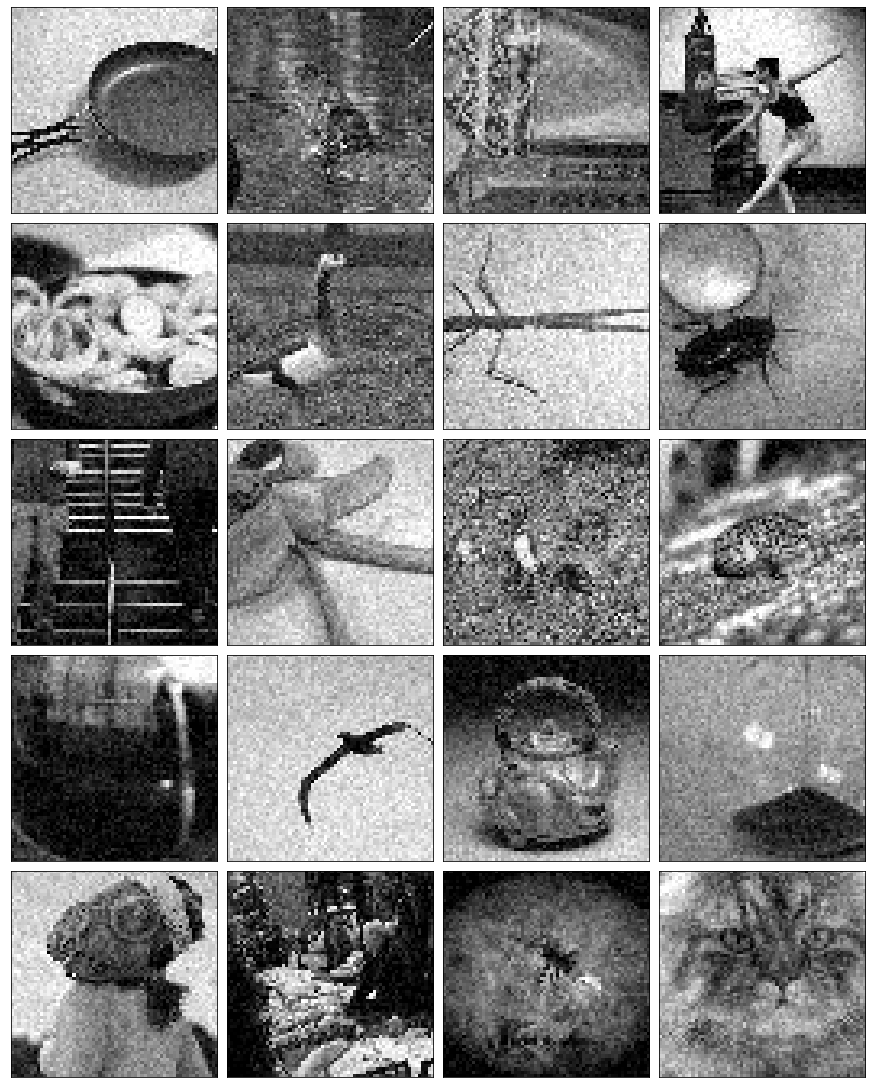


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the training denoising results]



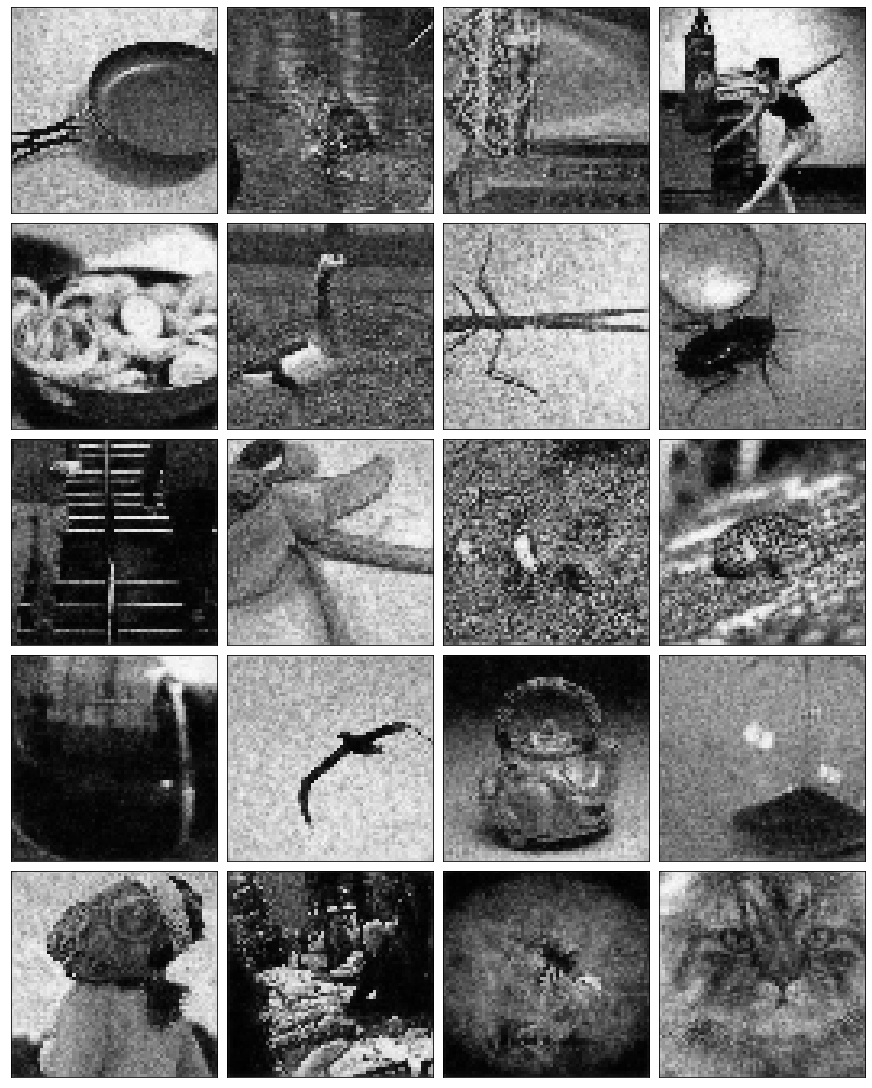


################################################################################
#
# RESULT # 03
#
################################################################################

[plot examples of the testing images]



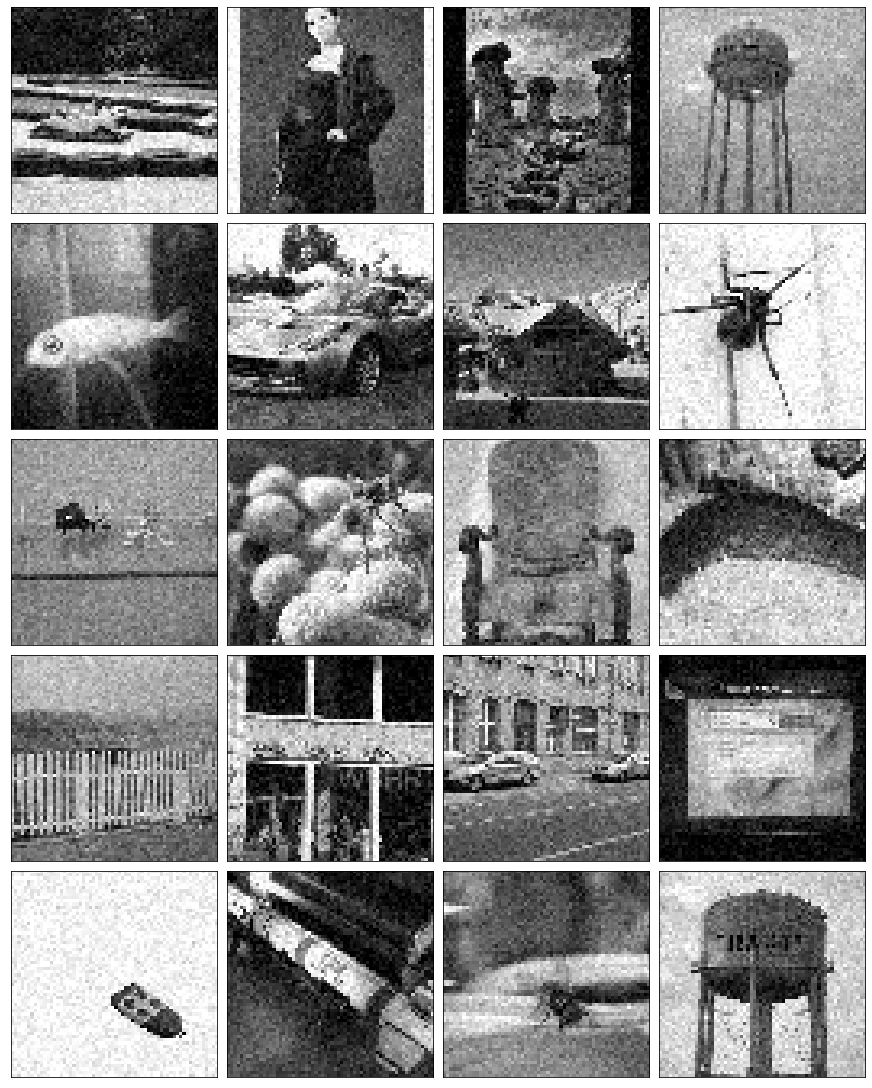


################################################################################
#
# RESULT # 04
#
################################################################################

[plot examples of the testing denoising results]



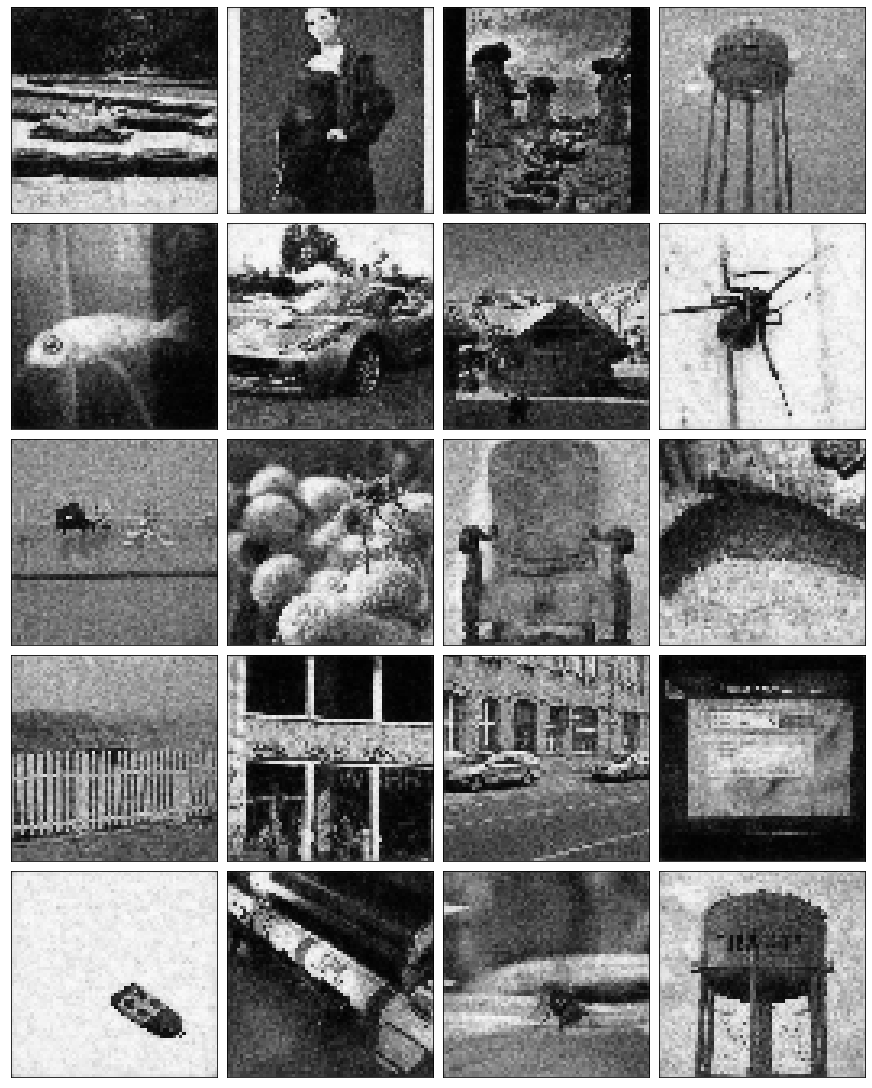


################################################################################
#
# RESULT # 05
#
################################################################################

[plot the training loss]



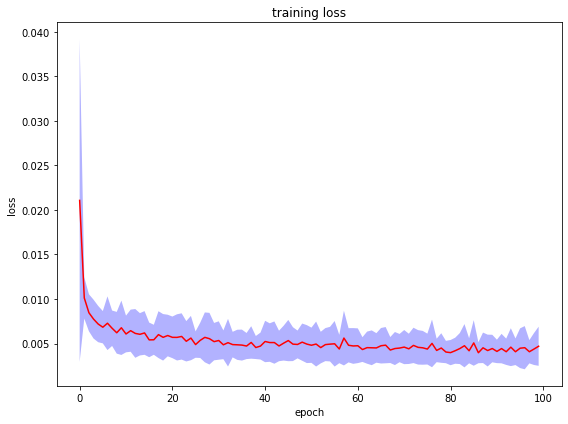


################################################################################
#
# RESULT # 06
#
################################################################################

[plot the training fidelity loss]



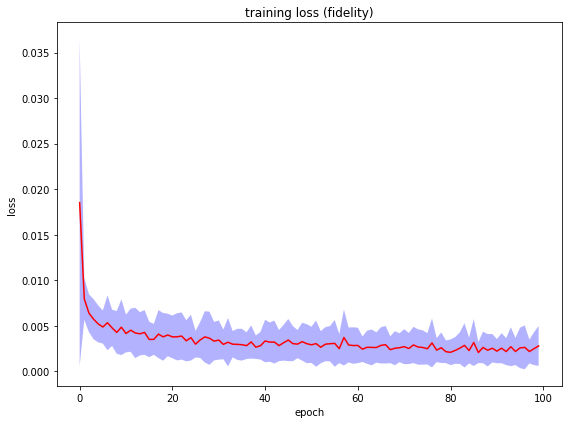


################################################################################
#
# RESULT # 07
#
################################################################################

[plot the training regularization loss]



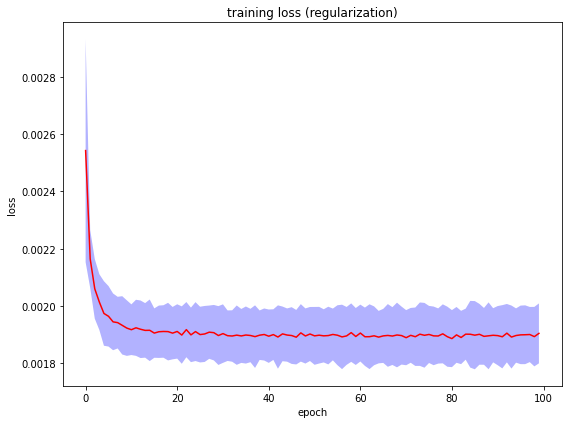


################################################################################
#
# RESULT # 08
#
################################################################################

[plot the training PSNR]



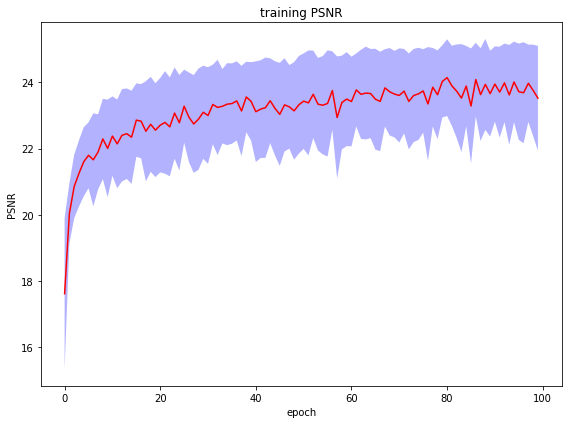


################################################################################
#
# RESULT # 09
#
################################################################################

[plot the testing loss]



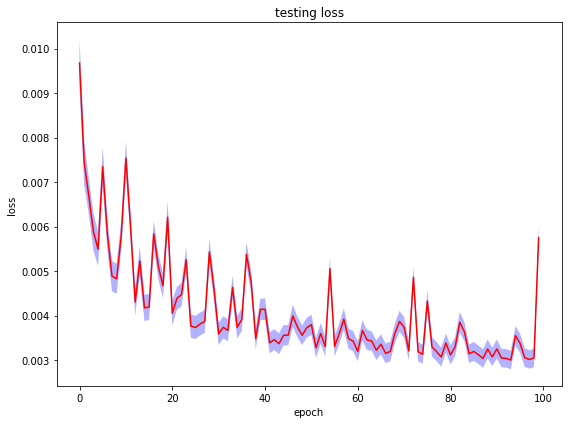


################################################################################
#
# RESULT # 10
#
################################################################################

[plot the testing fidelity loss]



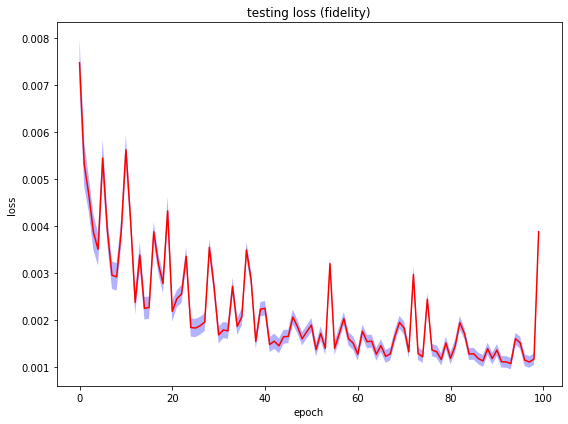


################################################################################
#
# RESULT # 11
#
################################################################################

[plot the testing regularization loss]



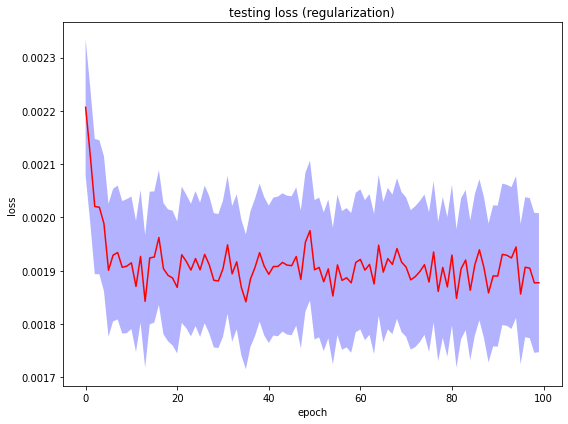


################################################################################
#
# RESULT # 12
#
################################################################################

[plot the testing PSNR]



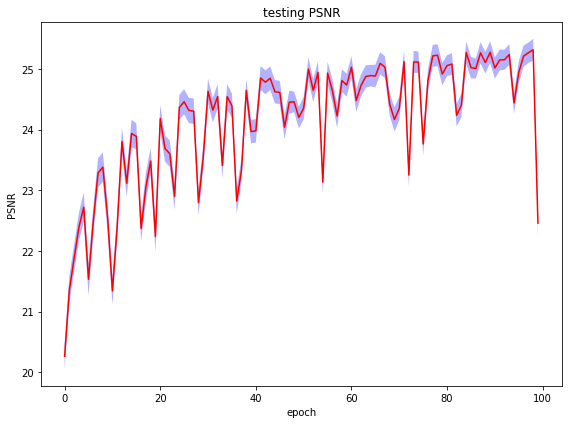


################################################################################
#
# RESULT # 13
#
################################################################################

[print the training loss (mean) at the last 10 epochs]

index =  0, value = 0.0041154542
index =  1, value = 0.0044338113
index =  2, value = 0.0040786508
index =  3, value = 0.0045929821
index =  4, value = 0.0040783618
index =  5, value = 0.0044743027
index =  6, value = 0.0045334165
index =  7, value = 0.0040785100
index =  8, value = 0.0043830188
index =  9, value = 0.0046947293

################################################################################
#
# RESULT # 14
#
################################################################################

[print the training PSNR (mean) at the last 10 epochs]

index =  0, value = 23.9492088037
index =  1, value = 23.7068833401
index =  2, value = 23.9856187288
index =  3, value = 23.6213783442
index =  4, value = 24.0125371617
index =  5, value = 23.7

In [43]:
number_result = 18

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)